# Preprocessing and Feature Engineering


### Importing packages


In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

### Loading data


In [137]:
data = pd.read_csv("consumption_and_temperatures.csv")
data.head()

,timestamp,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
0,2017-05-01 00:00:00+00:00,3325.431995,2.1,3534.588,5.0,2674.838,5.5,2061.209,0.2,1609.089,3.9
1,2017-05-01 01:00:00+00:00,3344.690998,1.8,3560.209,4.1,2678.188,4.0,2045.436,0.1,1623.485,3.2
2,2017-05-01 02:00:00+00:00,3398.359002,3.2,3596.149,3.1,2678.341,3.7,2020.007,0.1,1634.128,2.7
3,2017-05-01 03:00:00+00:00,3430.220001,3.6,3594.042,2.3,2684.172,3.2,2021.920,0.1,1647.906,2.3
4,2017-05-01 04:00:00+00:00,3606.750000,3.4,3665.091,2.6,2733.345,2.7,2045.913,0.1,1679.176,2.3


## Preprocessing


### Checking for holes


In [138]:
data.isna().sum()

timestamp          0
NO1_consumption    0
NO1_temperature    0
NO2_consumption    0
NO2_temperature    0
NO3_consumption    0
NO3_temperature    0
NO4_consumption    0
NO4_temperature    0
NO5_consumption    0
NO5_temperature    0
dtype: int64

### Converting timestamp to datetime and set as index


In [139]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.set_index("timestamp", inplace=True)
data.head()

,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
timestamp,,,,,,,,,,
2017-05-01 00:00:00+00:00,3325.431995,2.1,3534.588,5.0,2674.838,5.5,2061.209,0.2,1609.089,3.9
2017-05-01 01:00:00+00:00,3344.690998,1.8,3560.209,4.1,2678.188,4.0,2045.436,0.1,1623.485,3.2
2017-05-01 02:00:00+00:00,3398.359002,3.2,3596.149,3.1,2678.341,3.7,2020.007,0.1,1634.128,2.7
2017-05-01 03:00:00+00:00,3430.220001,3.6,3594.042,2.3,2684.172,3.2,2021.920,0.1,1647.906,2.3
2017-05-01 04:00:00+00:00,3606.750000,3.4,3665.091,2.6,2733.345,2.7,2045.913,0.1,1679.176,2.3


### Splitting into training, validation and testing data


In [144]:
train, test = train_test_split(data, test_size=0.2, train_size=0.8, shuffle=False)
train, val = train_test_split(train, test_size=0.25, shuffle=False)

test.to_csv("test.csv", index=True)
val.to_csv("validation.csv", index=True)

### Splitting temperature and consumption


In [146]:
temp_features = [
    "NO1_temperature",
    "NO2_temperature",
    "NO3_temperature",
    "NO4_temperature",
    "NO5_temperature",
]

cons_features = [
    "NO1_consumption",
    "NO2_consumption",
    "NO3_consumption",
    "NO4_consumption",
    "NO5_consumption",
]

temp = train[temp_features]
cons = train[cons_features]

temp.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature
timestamp,,,,,
2017-05-01 00:00:00+00:00,2.1,5.0,5.5,0.2,3.9
2017-05-01 01:00:00+00:00,1.8,4.1,4.0,0.1,3.2
2017-05-01 02:00:00+00:00,3.2,3.1,3.7,0.1,2.7
2017-05-01 03:00:00+00:00,3.6,2.3,3.2,0.1,2.3
2017-05-01 04:00:00+00:00,3.4,2.6,2.7,0.1,2.3


### Plotting data


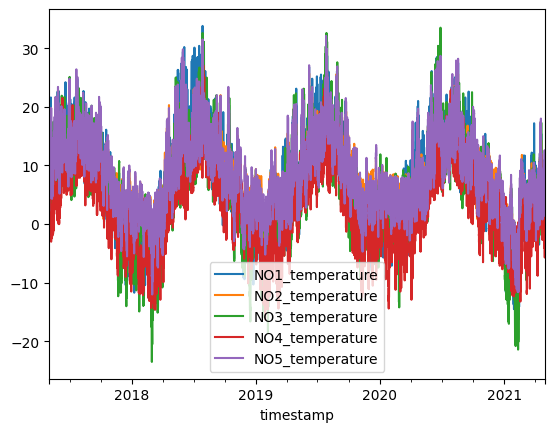

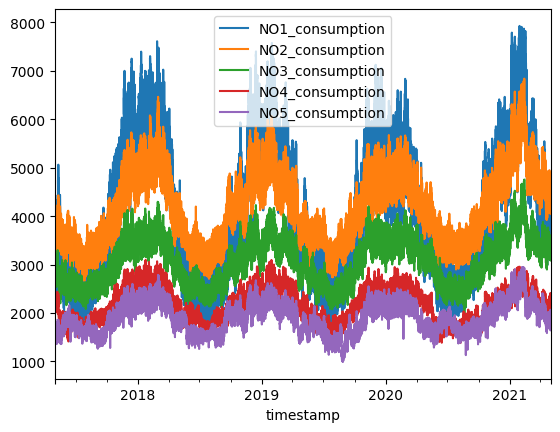

In [147]:
temp.plot()
cons.plot()
plt.show()

### Identifying spikes and replacing with holes


In [148]:
def remove_spikes(data, threshold=3.2):
    tensor = torch.tensor(data.values)
    mean = tensor.mean()
    std = tensor.std()
    z_scores = (tensor - mean) / std
    spike_indices = (z_scores > threshold) | (z_scores < -threshold)
    tensor[spike_indices] = float("nan")
    return pd.DataFrame(tensor, index=data.index, columns=data.columns)


temp = remove_spikes(temp)
cons = remove_spikes(cons)
temp.isna().sum(), cons.isna().sum()

(NO1_temperature     23
 NO2_temperature      8
 NO3_temperature    184
 NO4_temperature      0
 NO5_temperature     12
 dtype: int64,
 NO1_consumption    684
 NO2_consumption      0
 NO3_consumption      0
 NO4_consumption      0
 NO5_consumption      0
 dtype: int64)

### Replacing holes with interpolation


In [149]:
temp = temp.interpolate()
cons = cons.interpolate()
temp.isna().sum(), temp.isna().sum()

(NO1_temperature    0
 NO2_temperature    0
 NO3_temperature    0
 NO4_temperature    0
 NO5_temperature    0
 dtype: int64,
 NO1_temperature    0
 NO2_temperature    0
 NO3_temperature    0
 NO4_temperature    0
 NO5_temperature    0
 dtype: int64)

### Plotting without spikes


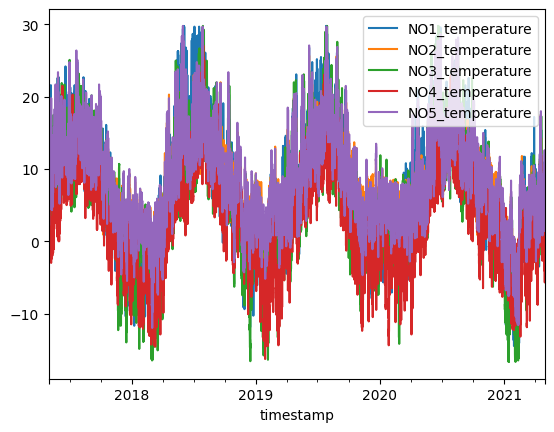

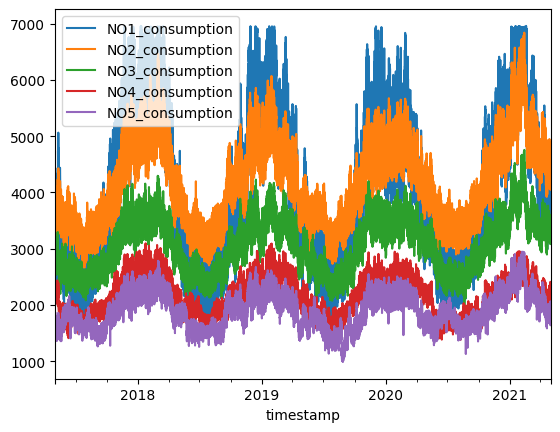

In [150]:
temp.plot()
cons.plot()
plt.show()

### Normalization


In [152]:
# save normalization parameters to transform back to original scale:
temp_tensor = torch.tensor(temp.values)
cons_tensor = torch.tensor(cons.values)

p, eps = (2, 1e-12)

norm_params = {"temperature": (p, eps), "consumption": (p, eps)}

torch.save(norm_params, "normalization_params.pt")

temp_norm = F.normalize(input=temp_tensor, dim=0, p=p, eps=eps)
cons_norm = F.normalize(input=cons_tensor, dim=0, p=p, eps=eps)

temp = pd.DataFrame(temp_norm, index=temp.index, columns=temp.columns)
cons = pd.DataFrame(cons_norm, index=cons.index, columns=cons.columns)

temp.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature
timestamp,,,,,
2017-05-01 00:00:00+00:00,0.001028,0.002611,0.002990,0.000147,0.001999
2017-05-01 01:00:00+00:00,0.000881,0.002141,0.002175,0.000074,0.001640
2017-05-01 02:00:00+00:00,0.001566,0.001619,0.002012,0.000074,0.001384
2017-05-01 03:00:00+00:00,0.001762,0.001201,0.001740,0.000074,0.001179
2017-05-01 04:00:00+00:00,0.001664,0.001358,0.001468,0.000074,0.001179


### Plotting normalized data


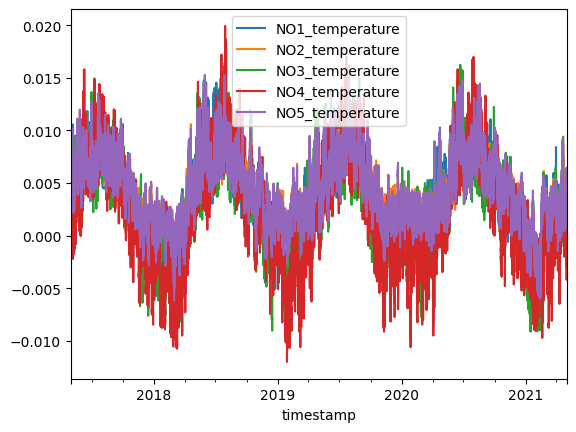

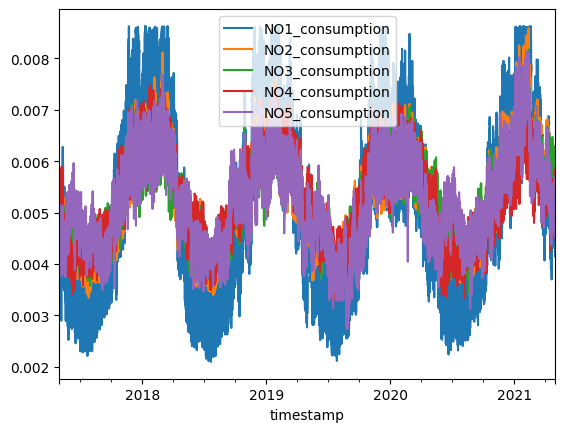

In [153]:
temp.plot()
cons.plot()
plt.show()

### Updating data to preprocessed version


In [154]:
train = pd.concat([temp, cons], axis=1)
train.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption
timestamp,,,,,,,,,,
2017-05-01 00:00:00+00:00,0.001028,0.002611,0.002990,0.000147,0.001999,0.004123,0.004436,0.004594,0.004982,0.004441
2017-05-01 01:00:00+00:00,0.000881,0.002141,0.002175,0.000074,0.001640,0.004147,0.004468,0.004600,0.004944,0.004481
2017-05-01 02:00:00+00:00,0.001566,0.001619,0.002012,0.000074,0.001384,0.004214,0.004513,0.004600,0.004883,0.004510
2017-05-01 03:00:00+00:00,0.001762,0.001201,0.001740,0.000074,0.001179,0.004253,0.004510,0.004611,0.004887,0.004548
2017-05-01 04:00:00+00:00,0.001664,0.001358,0.001468,0.000074,0.001179,0.004472,0.004600,0.004695,0.004945,0.004634


## Feature engineering


### Date and time features


In [156]:
train["time_of_day"] = train.index.hour
train["day_of_week"] = train.index.dayofweek
train["day_of_year"] = train.index.dayofyear

train.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption,time_of_day,day_of_week,day_of_year
timestamp,,,,,,,,,,,,,
2017-05-01 00:00:00+00:00,0.001028,0.002611,0.002990,0.000147,0.001999,0.004123,0.004436,0.004594,0.004982,0.004441,0,0,121
2017-05-01 01:00:00+00:00,0.000881,0.002141,0.002175,0.000074,0.001640,0.004147,0.004468,0.004600,0.004944,0.004481,1,0,121
2017-05-01 02:00:00+00:00,0.001566,0.001619,0.002012,0.000074,0.001384,0.004214,0.004513,0.004600,0.004883,0.004510,2,0,121
2017-05-01 03:00:00+00:00,0.001762,0.001201,0.001740,0.000074,0.001179,0.004253,0.004510,0.004611,0.004887,0.004548,3,0,121
2017-05-01 04:00:00+00:00,0.001664,0.001358,0.001468,0.000074,0.001179,0.004472,0.004600,0.004695,0.004945,0.004634,4,0,121


### Dump feature engineered data


In [ ]:
train.to_csv("train.csv", index=True)